# Non-linear Regression
- LOWESS
- Polynomial Regression
- MARS
- Spines

## Data

Here is a simple dataset that shows apparent non-linearity

In [1]:
import numpy
from matplotlib import pyplot as plt
import pandas as pd
import warnings

In [2]:
#Use the mgp dataset
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv'
df = pd.read_csv(url)
df = df.dropna()

Text(0, 0.5, 'mpg')

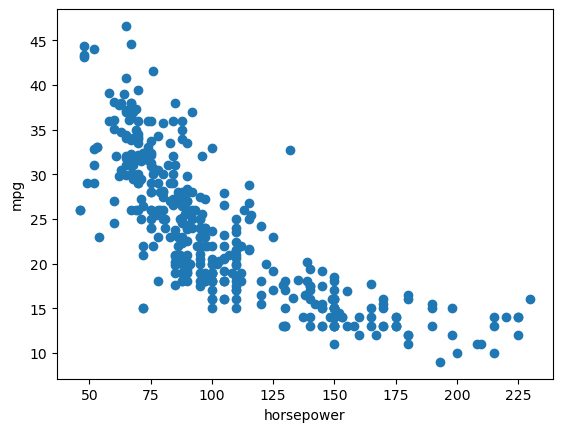

In [3]:
plt.scatter(df.horsepower,df.mpg)
plt.xlabel('horsepower')
plt.ylabel('mpg')

In [4]:
y = df.mpg.values.reshape(-1,1)
X = df.horsepower.values.reshape(-1,1)

## LOWESS

In [5]:
import statsmodels.api as sm

Text(0.5, 1.0, 'frac=0.5')

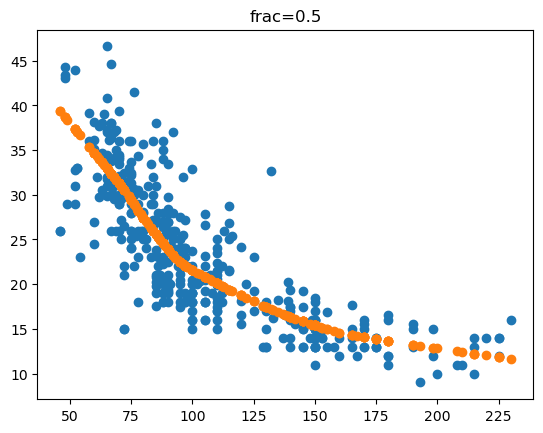

In [6]:
#fits the data, set the frac parameter (bandwidth)
z = sm.nonparametric.lowess(y.reshape(-1), X.reshape(-1), frac=0.5)

plt.scatter(X,y.reshape(-1))
plt.scatter(z[:,0],z[:,1])
plt.title("frac=0.5")

Text(0.5, 1.0, 'frac=0.1')

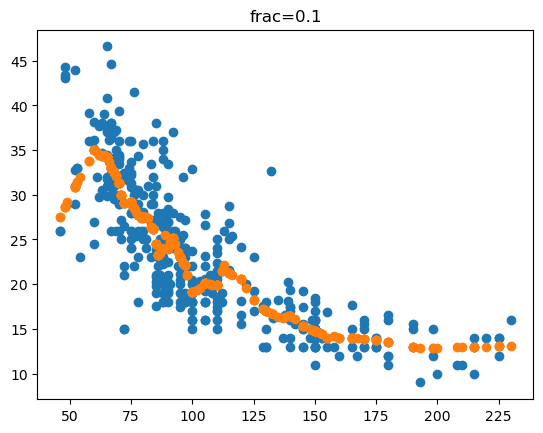

In [7]:
#fits the data, set the frac parameter (bandwidth)
z = sm.nonparametric.lowess(y.reshape(-1), X.reshape(-1), frac=0.1)

plt.scatter(X,y.reshape(-1))
plt.scatter(z[:,0],z[:,1])
plt.title("frac=0.1")

Text(0.5, 1.0, 'frac=1')

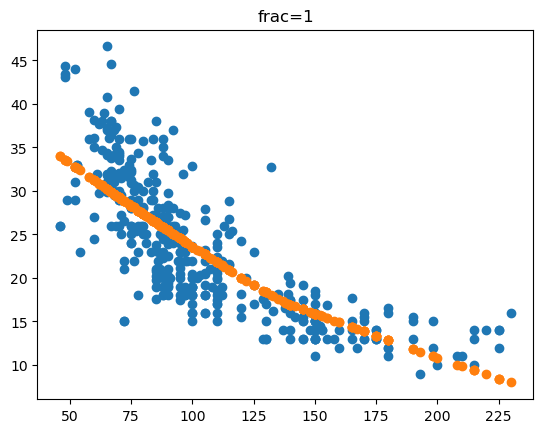

In [8]:
#fits the data, set the frac parameter (bandwidth)
z = sm.nonparametric.lowess(y.reshape(-1), X.reshape(-1), frac=1)

plt.scatter(X,y.reshape(-1))
plt.scatter(z[:,0],z[:,1])
plt.title("frac=1")

As the fraction which is the bandwidth increases, the fitted curve tend to be smoother fewer wiggliness.

## Polynomial Regression

In [9]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=2) #define polynomial degrees

xp = polynomial_features.fit_transform(X)
xp.shape

(392, 3)

In [10]:
xp = pd.DataFrame(xp, columns=["intercept","X","X_squared"])

Text(0.5, 1.0, 'Car Example')

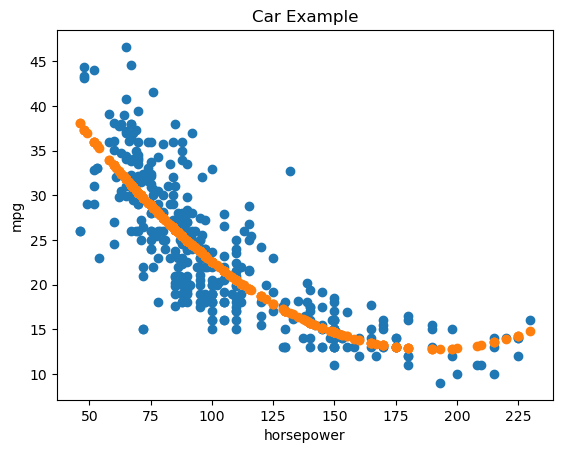

In [11]:
import statsmodels.api as sm

model = sm.OLS(y, xp).fit()
ypred = model.predict()

plt.scatter(X,y)
plt.scatter(X,ypred)

plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('Car Example')

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           5.40e-99
Time:                        21:59:18   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     56.9001      1.800     31.604      0.000      53.360      60.440
X             -0.4662      0.031    -14.978      0.000      -0.527      -0.405
X_squared      0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Estimated regression "curve": y_pred = 56.9001 + -0.4662*X + 0.0012* X^2

## MARS (Multivariate adaptive regression spline)

The python MARS pakcage `pyearth` is not active now, so there is no available MARS implementation in python. MARS itself is not too complicated. Essentially it can decompose to two steps:
- 1. to generate hinge basis functions.
- 2. to do a forward search by adding the best hinge basis function one at a time.
- 3. (optional but usually needed) to do a backward search by removing hinge basis function while achieving a higher AIC/BIC/GCV score to avoid over fitting. 

Below provides a simple implementation of MARS just to show the idea.


In [13]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [14]:
def generate_two_sided_hinge_basis(X, num_eq_knots=5, q=4,varname='_'):
    """
    Generate two-sided hinge basis functions for variable X based on equally spaced knots and quantile knots.

    Each knot generates both:
        - Positive hinge: max(0, X - c)
        - Negative hinge: max(0, c - X)

    Parameters:
    -----------
    X : array-like, shape (n_samples,)
        Input variable.

    num_eq_knots : int, default=5
        Number of equally spaced knots between min(X) and max(X).

    q : int, default=4
        Number of quantiles to determine knot locations (e.g., q=4 for quartiles).

    Returns:
    --------
    hinge_df : pandas.DataFrame
        DataFrame where each column is a two-sided hinge basis function.
    """
    X = np.array(X)
    min_X, max_X = np.min(X), np.max(X)
    
    # Generate equally spaced knots (excluding min and max)
    #eq_knots = np.linspace(min_X, max_X, num_eq_knots + 2)[1:-1]
    
    # Generate quantile-based knots (excluding 0 and 1)
    quantiles = np.linspace(0, 1, q + 2)[1:-1]
    quantile_knots = np.quantile(X, quantiles)
    
    # Combine and remove duplicate knots
    all_knots = quantile_knots#np.unique(np.concatenate([eq_knots, quantile_knots]))
    
    # Create two-sided hinge basis functions
    hinge_functions = {}
    for i, c in enumerate(all_knots):
        # Positive hinge: max(0, X - c)
        pos_hinge_name = varname + f'hinge_pos_{i+1}_c{c:.2f}'
        hinge_functions[pos_hinge_name] = np.maximum(0, X - c)
        
        # Negative hinge: max(0, c - X)
        neg_hinge_name = varname + f'hinge_neg_{i+1}_c{c:.2f}'
        hinge_functions[neg_hinge_name] = np.maximum(0, c - X)
    
    hinge_df = pd.DataFrame(hinge_functions)
    return hinge_df

In [15]:


def forward_selection(X, y, max_terms=10, threshold=1e-4):
    """
    Perform forward selection to select variables that maximize the reduction
    in sum-of-squares residual (SSR) error.

    Parameters:
    - X: pd.DataFrame, predictor variables
    - y: pd.Series or pd.DataFrame, target variable
    - max_terms: int, maximum number of variables to include in the model
    - threshold: float, minimum change in SSR to continue adding variables

    Returns:
    - selected_vars: list of selected variable names
    - model: the final fitted statsmodels OLS regression model
    - ssr_history: list of SSR values at each step
    """
    selected_vars = []
    remaining_vars = list(X.columns)
    ssr_history = []
    current_ssr = np.inf  # Initialize with infinity

    for step in range(max_terms):
        best_ssr = current_ssr
        best_var = None
        
        m = 0
        for var in remaining_vars:
            
            if m == 1:
                m = 0
                continue
            
            next_var = remaining_vars[remaining_vars.index(var) + 1]
            candidate_vars = selected_vars + [var, next_var]
            print(var, next_var)
            m = 1
            
            X_candidate = sm.add_constant(X[candidate_vars])  # Adds intercept
            model = sm.OLS(y, X_candidate).fit()
            ssr = np.sum(model.resid ** 2)

            # Debug: Print candidate variable and its SSR
            print(f"Step {step+1}: Evaluating variable '{var}': SSR = {ssr:.4f}")

            if ssr < best_ssr:
                best_ssr = ssr
                best_var = var

        # Check if the best variable found reduces SSR sufficiently
        if best_var is not None:
            ssr_reduction = current_ssr - best_ssr
            print(f"Step {step+1}: Selected variable '{best_var}' with SSR reduction {ssr_reduction:.4f}")

            if ssr_reduction < threshold:
                print(f"SSR reduction {ssr_reduction:.4f} is below the threshold {threshold}. Stopping.")
                break

            selected_vars.append(best_var)
            selected_vars.append(next_var)
            
            remaining_vars.remove(best_var)
            remaining_vars.remove(next_var)
            
            ssr_history.append(best_ssr)
            current_ssr = best_ssr
        else:
            # No improvement found
            print("No further improvement. Stopping.")
            break

    # Fit the final model with selected variables
    if selected_vars:
        X_final = sm.add_constant(X[selected_vars])
        final_model = sm.OLS(y, X_final).fit()
    else:
        # If no variables selected, model with only intercept
        X_final = sm.add_constant(pd.DataFrame({'Intercept': np.ones(len(y))}))
        final_model = sm.OLS(y, X_final).fit()
    
    prediction = final_model.predict(X_final)
    print("Final Selected:", selected_vars)

    return selected_vars, final_model, ssr_history,prediction





Generate hinge basis

In [16]:
X_all = generate_two_sided_hinge_basis(X.reshape(-1),q=4,varname='X1_')

In [17]:
X_all.head()

,X1_hinge_pos_1_c72.00,X1_hinge_neg_1_c72.00,X1_hinge_pos_2_c88.00,X1_hinge_neg_2_c88.00,X1_hinge_pos_3_c100.00,X1_hinge_neg_3_c100.00,X1_hinge_pos_4_c140.00,X1_hinge_neg_4_c140.00
0,58.0,0.0,42.0,0.0,30.0,0.0,0.0,10.0
1,93.0,0.0,77.0,0.0,65.0,0.0,25.0,0.0
2,78.0,0.0,62.0,0.0,50.0,0.0,10.0,0.0
3,78.0,0.0,62.0,0.0,50.0,0.0,10.0,0.0
4,68.0,0.0,52.0,0.0,40.0,0.0,0.0,0.0


Forward search. Adding new term stops when residual sum of squares (SSR) is not improving.

In [18]:
selected_vars, final_model, ssr_history,prediction = forward_selection(X_all, y, 4)

X1_hinge_pos_1_c72.00 X1_hinge_neg_1_c72.00
Step 1: Evaluating variable 'X1_hinge_pos_1_c72.00': SSR = 8793.2936
X1_hinge_pos_2_c88.00 X1_hinge_neg_2_c88.00
Step 1: Evaluating variable 'X1_hinge_pos_2_c88.00': SSR = 7862.0687
X1_hinge_pos_3_c100.00 X1_hinge_neg_3_c100.00
Step 1: Evaluating variable 'X1_hinge_pos_3_c100.00': SSR = 7434.5318
X1_hinge_pos_4_c140.00 X1_hinge_neg_4_c140.00
Step 1: Evaluating variable 'X1_hinge_pos_4_c140.00': SSR = 7755.0215
Step 1: Selected variable 'X1_hinge_pos_3_c100.00' with SSR reduction inf
X1_hinge_pos_1_c72.00 X1_hinge_neg_1_c72.00
Step 2: Evaluating variable 'X1_hinge_pos_1_c72.00': SSR = 7244.1669
X1_hinge_pos_2_c88.00 X1_hinge_neg_2_c88.00
Step 2: Evaluating variable 'X1_hinge_pos_2_c88.00': SSR = 7279.2129
X1_hinge_neg_3_c100.00 X1_hinge_pos_4_c140.00
Step 2: Evaluating variable 'X1_hinge_neg_3_c100.00': SSR = 7286.3668
Step 2: Selected variable 'X1_hinge_pos_1_c72.00' with SSR reduction 190.3650
X1_hinge_neg_1_c72.00 X1_hinge_pos_2_c88.00
Step

The forward searching will select 100 as a cut point (knot) and then 72 for the left and 140 for the right cut.

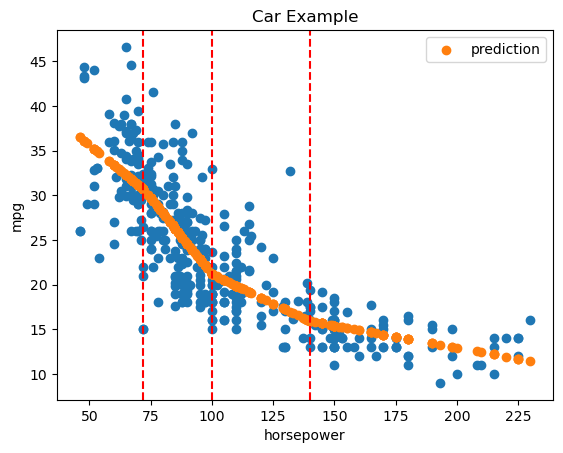

In [19]:
import statsmodels.api as sm

model = sm.OLS(y, xp).fit()
ypred = model.predict()

plt.scatter(X,y)
plt.scatter(X,prediction,label='prediction')

#Knot locations
plt.axvline(x=100, color='red', linestyle='--')
plt.axvline(x=140, color='red', linestyle='--')
plt.axvline(x=72, color='red', linestyle='--')

plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('Car Example')
plt.legend()

## GAM via pygam

`pygam`: https://pygam.readthedocs.io/en/latest/index.html

In [20]:
#pip install pygam

In [21]:
from pygam import GAM, s,te

`s` here refers to a curve smoother

In [22]:
gam = GAM(s(0))
gam.fit(X, y)

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + intercept, tol=0.0001, verbose=False)

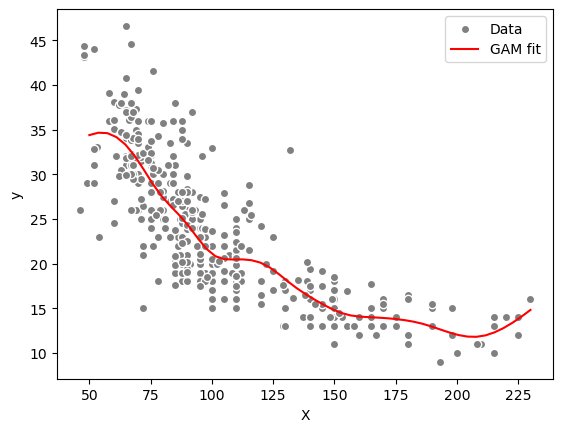

In [23]:
XX = np.linspace(50, 230, 50).reshape(-1, 1)
y_pred = gam.predict(XX)

# Plot the original data and the model predictions
plt.scatter(X, y, facecolor='gray', edgecolor='white', label='Data')
plt.plot(XX, y_pred, color='red', label='GAM fit')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [24]:
gam = GAM(s(0),lam=1000)
gam.fit(X, y)

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + intercept, tol=0.0001, verbose=False)

Text(0.5, 1.0, 'lam=1000')

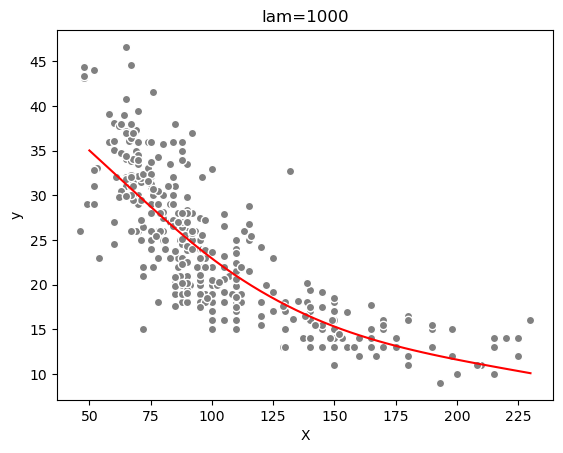

In [25]:
XX = np.linspace(50, 230, 50).reshape(-1, 1)
y_pred = gam.predict(XX)

# Plot the original data and the model predictions
plt.scatter(X, y, facecolor='gray', edgecolor='white', label='Data')
plt.plot(XX, y_pred, color='red', label='GAM fit')
plt.xlabel('X')
plt.ylabel('y')
plt.title("lam=1000")

In [26]:
gam = GAM(s(0),lam=0.001) #lam=0.001
gam.fit(X, y)

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + intercept, tol=0.0001, verbose=False)

Text(0.5, 1.0, 'lam=0.001')

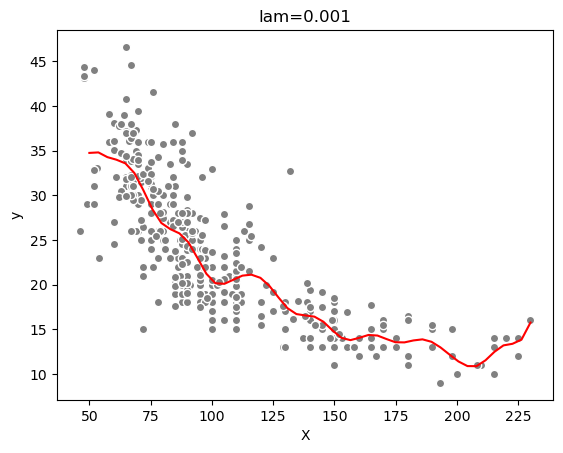

In [27]:
XX = np.linspace(50, 230, 50).reshape(-1, 1)
y_pred = gam.predict(XX)

# Plot the original data and the model predictions
plt.scatter(X, y, facecolor='gray', edgecolor='white', label='Data')
plt.plot(XX, y_pred, color='red', label='GAM fit')
plt.xlabel('X')
plt.ylabel('y')
plt.title("lam=0.001")

A grid search over some possible lambda value.

In [28]:
lambda_range = np.logspace(-3, 3, 10)

# Perform grid search to find the optimal lambda
gam.gridsearch(X, y, lam=lambda_range)


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + intercept, tol=0.0001, verbose=False)

Text(0, 0.5, 'y')

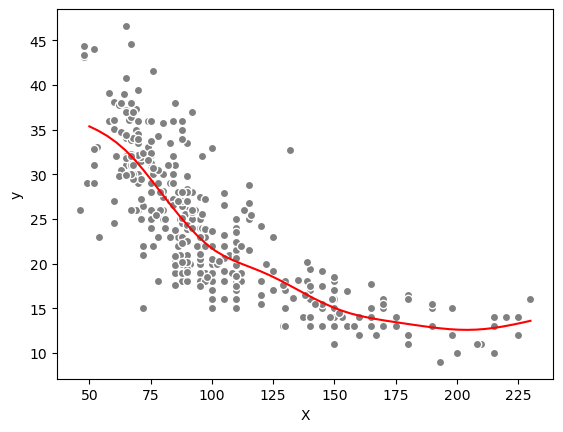

In [29]:
XX = np.linspace(50, 230, 50).reshape(-1, 1)
y_pred = gam.predict(XX)

# Plot the original data and the model predictions
plt.scatter(X, y, facecolor='gray', edgecolor='white', label='Data')
plt.plot(XX, y_pred, color='red', label='GAM fit')
plt.xlabel('X')
plt.ylabel('y')


With confidence interval

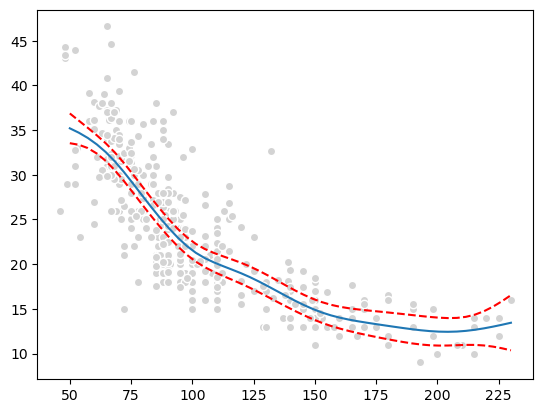

In [30]:
plt.scatter(X, y, facecolor='lightgray', edgecolor='white', label='Data')
pdep, confi = gam.partial_dependence(term=0, X=XX, width=0.95)
plt.plot(XX, pdep + y_pred.mean())
plt.plot(XX, confi + y_pred.mean(), c='r', ls='--')
#plt.title(repr(term))


# The `meuse` example

In [31]:
meuse = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/GIS5122/refs/heads/spring-25/data/meuse.csv")

In [32]:
meuse.head()

,Unnamed: 0,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,log_zinc,gam_residuals,optional
0,1,181072,333611,11.7,85,299,1022,7.909,0.001358,13.6,1,1,1,Ah,50,6.929517,0.087034,True
1,2,181025,333558,8.6,81,277,1141,6.983,0.012224,14.0,1,1,1,Ah,30,7.039660,-0.036256,True
2,3,181165,333537,6.5,68,199,640,7.800,0.103029,13.0,1,1,1,Ah,150,6.461468,0.165954,True
3,4,181298,333484,2.6,81,116,257,7.655,0.190094,8.0,1,2,0,Ga,270,5.549076,-0.302885,True
4,5,181307,333330,2.8,48,117,269,7.480,0.277090,8.7,1,2,0,Ah,380,5.594711,-0.061886,True


In [33]:
y = np.log(meuse.zinc)

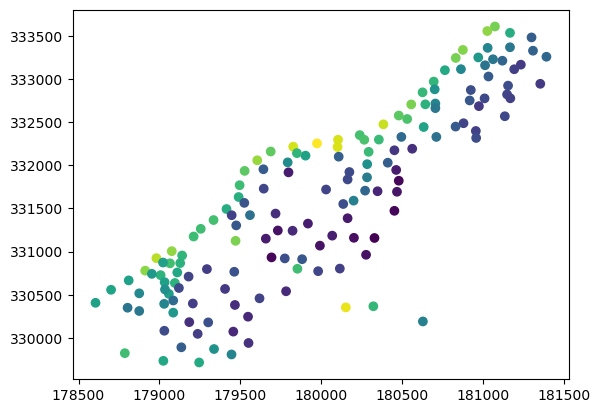

In [34]:
plt.scatter(meuse.x,meuse.y,c=y)

In [35]:
X = meuse[['elev', 'dist']].values

In [36]:
gam_meuse = GAM(s(0) + s(1))

In [37]:
lambda_range = np.logspace(-3, 3, 10)

# Perform grid search to find the optimal lambda
gam_meuse.gridsearch(X, y, lam=lambda_range)


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + intercept, tol=0.0001, verbose=False)

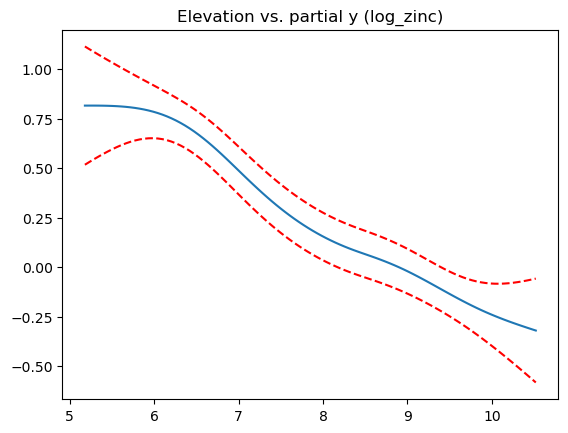

In [38]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam_meuse.generate_X_grid(term=i)
    pdep, confi = gam_meuse.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    if i == 0:
        plt.title("Elevation vs. partial y (log_zinc)")
    if i == 1:
        plt.title("Distance to river vs. partial y (log_zinc)")


In [39]:
gam_meuse.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.1359
Link Function:                     IdentityLink Log Likelihood:                                  -409.9921
Number of Samples:                          155 AIC:                                              838.2559
                                                AICc:                                             839.5343
                                                GCV:                                                0.1372
                                                Scale:                                              0.1243
                                                Pseudo R-Squared:                                   0.7725
Feature Function                  Lam

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_46381/4208143089.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_meuse.summary()


In [40]:
X2 = meuse[['elev', 'dist','x','y']].values

pyGAM can also fit interactions using tensor products via `te()`. Here `te()` can be used for the coordinates to generate a spatial surface similar to a spatial intercept.

In [41]:
gam_meuse2 = GAM(s(0) + s(1) + te(2,3))

In [42]:
gam_meuse2.gridsearch(X2, y, lam=lambda_range)

100% (10 of 10) |########################| Elapsed Time: 0:00:12 Time:  0:00:12


GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + te(2, 3) + intercept, tol=0.0001, 
   verbose=False)

In [43]:
gam_meuse2.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      28.713
Link Function:                     IdentityLink Log Likelihood:                                   -481.745
Number of Samples:                          155 AIC:                                             1022.9159
                                                AICc:                                            1037.6009
                                                GCV:                                                0.1311
                                                Scale:                                              0.0882
                                                Pseudo R-Squared:                                   0.8611
Feature Function                  Lam

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_46381/942188079.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_meuse2.summary()


In [44]:
gam_meuse2.terms

s(0) + s(1) + te(2, 3) + intercept

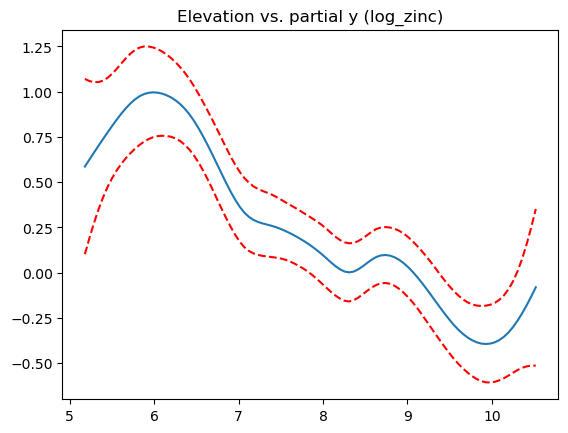

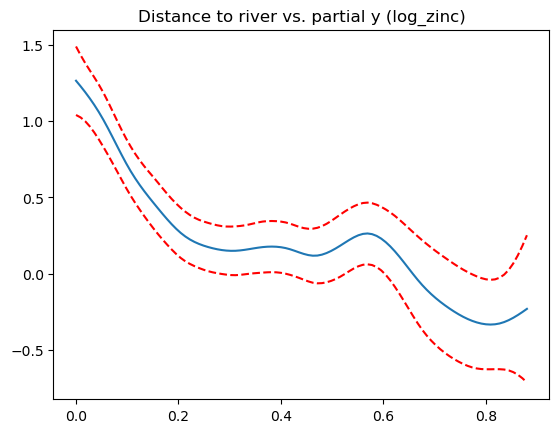

In [50]:
for i, term in enumerate(gam_meuse2.terms[:2]):
    if term.isintercept:
        continue

    XX = gam_meuse2.generate_X_grid(term=i)
    pdep, confi = gam_meuse2.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    if i == 0:
        plt.title("Elevation vs. partial y (log_zinc)")
    if i == 1:
        plt.title("Distance to river vs. partial y (log_zinc)")


Plot the spatial intercept

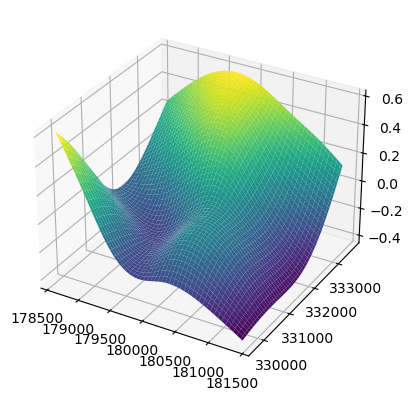

In [46]:
XX = gam_meuse2.generate_X_grid(term=2, meshgrid=True)
Z = gam_meuse2.partial_dependence(term=2, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

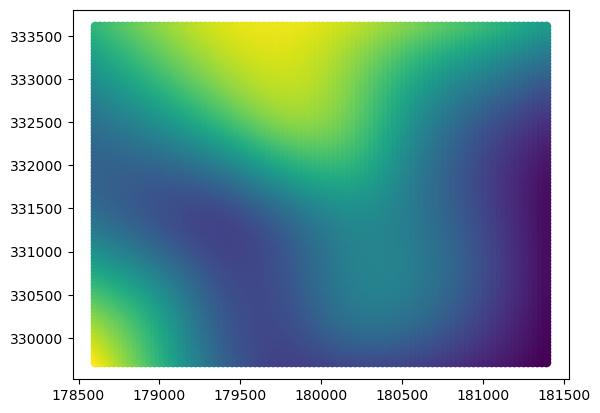

In [47]:
plt.scatter(XX[0], XX[1], c=Z)